In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.stats

In [ ]:
# Upload the link of GitHub
country_cases_file_link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv'
population_file_link = 'https://raw.githubusercontent.com/owid/covid-19-data/master/scripts/input/un/population_2020.csv'

In [ ]:
# Create dataframes based on the 2 links uploaded
cases_country_df = pd.read_csv(country_cases_file_link)
print(cases_country_df.shape) # Print the shape

population_df = pd.read_csv(population_file_link)
print(population_df.shape) # Print the shape

(195, 14)
(252, 4)


In [ ]:
cases_country_df = cases_country_df.replace(np.nan, '', regex=True) # Preprocess data

In [ ]:
cases_country_df # Print to view the dataframe

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3
0,Afghanistan,2021-07-03 08:21:18,33.9391,67.71,120216.0,4962.0,72700,42554,308.814,,,4.12757,4,AFG
1,Albania,2021-07-03 08:21:18,41.1533,20.1683,132526.0,2456.0,130018,52,4605.12,,,1.85322,8,ALB
2,Algeria,2021-07-03 08:21:18,28.0339,1.6596,140550.0,3735.0,97701,39114,320.517,,,2.65742,12,DZA
3,Andorra,2021-07-03 08:21:18,42.5063,1.5218,13918.0,127.0,13721,70,18013.3,,,0.912487,20,AND
4,Angola,2021-07-03 08:21:18,-11.2027,17.8739,39089.0,906.0,33375,4808,118.933,,,2.31779,24,AGO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Vietnam,2021-07-03 08:21:18,14.0583,108.277,18360.0,84.0,7395,10881,18.862,,,0.457516,704,VNM
191,West Bank and Gaza,2021-07-03 08:21:18,31.9522,35.2332,314409.0,3570.0,308413,2426,6163.17,,,1.13546,275,PSE
192,Yemen,2021-07-03 08:21:18,15.5527,48.5164,6924.0,1361.0,4082,1481,23.2147,,,19.6563,887,YEM
193,Zambia,2021-07-03 08:21:18,-13.1339,27.8493,160613.0,2341.0,137819,20453,873.659,,,1.45754,894,ZMB


In [ ]:
# Take necessary columns to create the global_data dataframe
global_data = cases_country_df[['Country_Region','Confirmed','Deaths','Recovered','Active', 'Incident_Rate', 'Mortality_Rate']]
global_data['Recovered'] = pd.to_numeric(global_data['Recovered'], errors='ignore')
global_data['Active'] = pd.to_numeric(global_data['Active'], errors='ignore')
global_data['Incident_Rate'] = pd.to_numeric(global_data['Incident_Rate'], errors='ignore')
global_data['Mortality_Rate'] = pd.to_numeric(global_data['Mortality_Rate'], errors='ignore')

# Global_summary is the sum of global_data
global_summary = pd.DataFrame(global_data.sum()).transpose()
global_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Country_Region,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality_Rate
0,AfghanistanAlbaniaAlgeriaAndorraAngolaAntigua ...,1.83099e+08,3.96414e+06,1.20305e+08,2.53879e+07,692045,430.802


In [ ]:
# SIR model differentiation equations function:
def ode(state, t, N, beta, gamma):
  S, I, R = state
  # Change in S population over time
  dSdt = -beta * S * I / N
  # Change in I population over time
  dIdt = beta * S * I / N - gamma * I
  # Change in R population over time
  dRdt = gamma * I
  return dSdt, dIdt, dRdt

R0 is 5.0


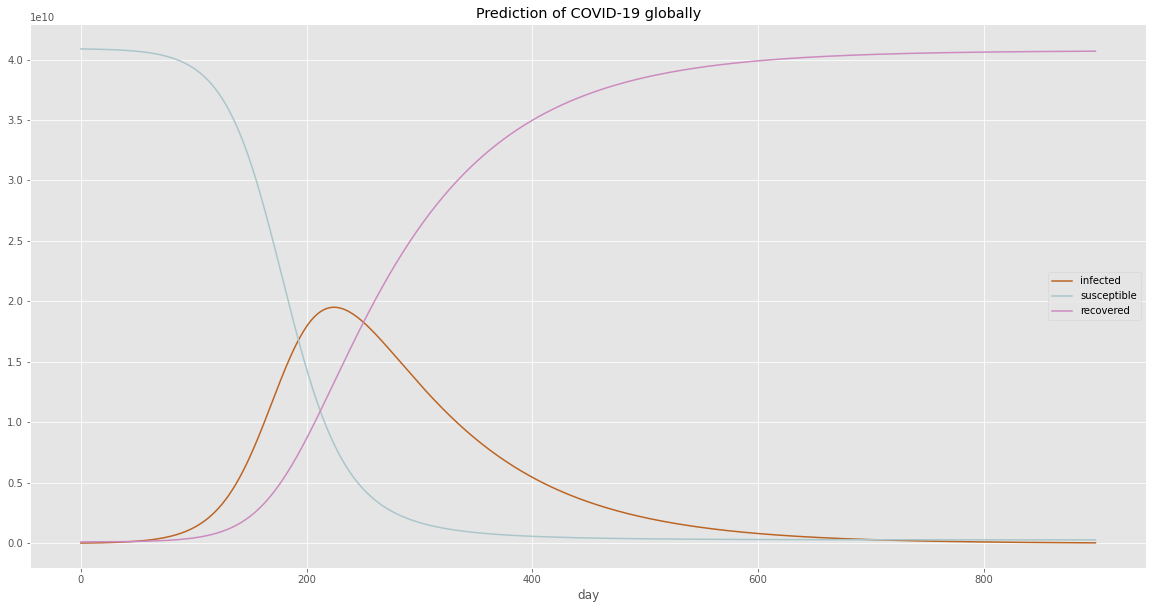

In [ ]:
effective_contact_rate = 0.05 # = transmission rate * contact rate
recovery_rate = 0.01      # = 1 / days

print("R0 is", effective_contact_rate / recovery_rate)

# State population in SIR model
# Everyone not infected or recovered is susceptible
total_pop = population_df['population'].sum()
recovered = (global_summary['Recovered'][0] + global_summary['Deaths'][0])
infected = global_summary['Active'][0]
susceptible = total_pop - infected - recovered

# A list of days, 0 -> 160
days = range(0,900)

# Use differential equations with the model
ret = odeint(ode, [susceptible,infected, recovered],days,args=(total_pop, effective_contact_rate, recovery_rate))
S, I, R = ret.T

# Build dataframe
df = pd.DataFrame({
    'susceptible': S,
    'infected': I,
    'recovered': R,
    'day': days
})

plt.style.use('ggplot')
df.plot(title = 'Prediction of COVID-19 globally',
        figsize=(20,10),
        x='day',
        y=['infected', 'susceptible', 'recovered'],
        color=['#bb6424', '#aac6ca', '#cc8ac0'],
        kind='line',
        stacked=False)


In [ ]:
df

,susceptible,infected,recovered,day
0,4.087767e+10,2.538793e+07,1.242690e+08,0
1,4.087638e+10,2.641919e+07,1.245280e+08,1
2,4.087504e+10,2.749230e+07,1.247975e+08,2
3,4.087364e+10,2.860895e+07,1.250779e+08,3
4,4.087219e+10,2.977090e+07,1.253698e+08,4
...,...,...,...,...
895,2.914280e+08,4.753228e+07,4.068837e+10,895
896,2.914112e+08,4.707604e+07,4.068884e+10,896
897,2.913946e+08,4.662418e+07,4.068931e+10,897
898,2.913781e+08,4.617666e+07,4.068977e+10,898


# Model for Country

In [ ]:
country_list = np.array(cases_country_df['Country_Region'])
country_list

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [ ]:
country = input("Which countries would you like? : ")

Which countries would you like? : Japan


In [ ]:
df_country = global_data[global_data['Country_Region'] == country]
df_country

,Country_Region,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality_Rate
87,Japan,804077.0,14783.0,769852.0,19442.0,635.752307,1.838506


R0 is 13.030104648497893
126476458.0
784635.0
87    19442.0
Name: Active, dtype: float64
87    125672381.0
Name: Active, dtype: float64


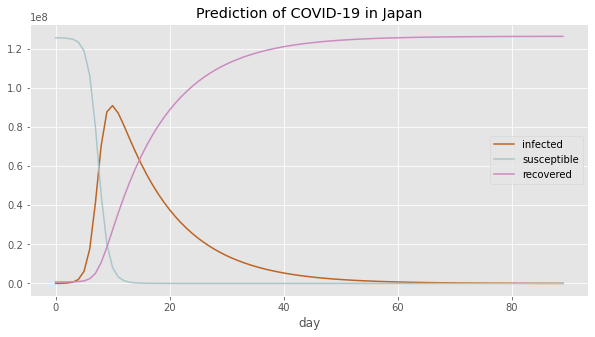

In [ ]:
effective_contact_rate = float(df_country['Incident_Rate']) * 0.002 # = transmission rate * contact rate
recovery_rate =  float(df_country['Mortality_Rate'] * (df_country['Deaths']  + df_country['Recovered']) / df_country['Deaths']) * 0.001    # = 1 / days

print("R0 is", effective_contact_rate / recovery_rate)

# State population in SIR model
# Everyone not infected or recovered is susceptible
total_pop = float(population_df[population_df['entity'] == 'Japan']['population'])
recovered = float(df_country['Recovered']) + float(df_country['Deaths'])
infected = df_country['Active']
susceptible = total_pop - infected - recovered
print(total_pop)
print(recovered)
print(infected)
print(susceptible)
# A list of days, 0 -> 160
days = range(0,90)

# Use differential equations with the model
ret = odeint(ode, [susceptible,infected, recovered],days,args=(total_pop, effective_contact_rate, recovery_rate))
S, I, R = ret.T

# Build dataframe
df = pd.DataFrame({
    'susceptible': S,
    'infected': I,
    'recovered': R,
    'day': days
})

plt.style.use('ggplot')
df.plot(figsize=(10,5),
        title='Prediction of COVID-19 in ' + country,
        x='day',
        y=['infected', 'susceptible', 'recovered'],
        color=['#bb6424', '#aac6ca', '#cc8ac0'],
        kind='line',
        stacked=False)


In [ ]:
df

,susceptible,infected,recovered,day
0,1.256724e+08,1.944200e+04,7.846350e+05,0
1,1.256259e+08,6.237005e+04,7.882288e+05,1
2,1.254768e+08,1.999064e+05,7.997528e+05,2
3,1.250009e+08,6.389214e+05,8.366368e+05,3
4,1.234987e+08,2.023782e+06,9.539925e+05,4
...,...,...,...,...
85,3.009060e+02,6.645611e+04,1.264097e+08,85
86,3.007145e+02,6.027772e+04,1.264159e+08,86
87,3.005410e+02,5.467374e+04,1.264215e+08,87
88,3.003836e+02,4.959076e+04,1.264266e+08,88
